In [31]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import root

from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.gradient_descent import SGD
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.initializers import initializers_v1

from google.colab import drive

drive.mount('/content/drive')

def P_F(q_0):                       
  return 1 - norm.cdf(q_0)             #вычисление вероятности ложной  тревоги

def P_D(q_0, q):

  return 1 - norm.cdf(q_0 - np.sqrt(2*q))       #вычисление вероятности правильного обнаружения

def fun(d_q):
  return P_F(d_q) - F


def find_q_0():
  return root(fun, np.array([0]), method = 'hybr')



def correlator(realization, signal_s, delta_t):
  return delta_t * realization.dot(signal_s)



def edu_vyborka_gen(num_s, num_n, sigma, t, signal_s):
  edu_s = []
  target_s = []
  edu_n = []
  target_n = []

  for i in range(num_s):

    #генерация реализаций с сигналом
    noise = sigma * np.random.randn(len(t))
    realization = signal_s + noise
    edu_s.append(realization)
    target_s.append(1)

  for i in range(num_n):
    #генерация реализаций без сигнала (только шум)
    noise = sigma * np.random.randn(len(t))
    realization = noise
    edu_n.append(realization)
    target_n.append(0)

  edu_s = np.asarray(edu_s)
  edu_n = np.asarray(edu_n)

  target_s = np.asarray(target_s)
  target_n = np.asarray(target_n)

  edu = np.concatenate((edu_s, edu_n), axis = 0)
  targets = np.concatenate((target_s, target_n), axis = 0)

  return edu, targets




def test_vyborka_gen(sigma, num_all, t, signal_s):
  test_s = []
  test_n = []


  for i in range(num_all):

    #генерация реализациий с сигналом

    noise = sigma * np.random.randn(len(t))
    realization = signal_s + noise
    test_s.append(realization)


    #генерация реализаций только с шумом, без сигнала

    noise = sigma * np.random.randn(len(t))
    realization = noise
    test_n.append(realization)


  test_s = np.asarray(test_s)
  test_n = np.asarray(test_n)

  return test_s, test_n



#параметры простого радиоимпульса, который нужно обнаружить


f_pch = 30*(10**3)
T = 1*(10**(-3))
phi_0 = 0

f_d = 1/T
T_d = 1/f_d

f_d_1 = 20*f_pch
T_d_1 = 1/f_d_1        #две частоты дискретизации, первая - после РЧБ, до обнаружителя

sigma_n = 1  #СКО АБГШ

#из СКО перейдем к спектральной плотности мощности АБГШ

N_0 = 2*sigma_n*sigma_n/f_d_1


rq = 3.2

E = rq*rq*N_0

A = np.sqrt(2*E/T)   #находим амплитуду сигнала


num = np.fix(T/T_d_1)
num = np.int(num)

t = np.linspace(0, T, num)

print('A =', A)

signal = A*np.cos(2 * np.pi * f_pch * t + phi_0)     #модель сигнала



#найдем количество выборок сигнала и шума

F = 0.001       #требуемая вероятность ложной тревоги

q_0 = find_q_0().x[0]    #важно перейти к соотношению априорных вероятностей

z_0 = q_0*rq*np.sqrt(2)


h = np.exp(z_0 - rq*rq)

print(h)

edu_num = 80000 #варьируемый параметр - это количество реализациий, которые будцт переданы для обучения

num_signal = int(edu_num/(1+h))      #количество реализаций с сигналом в обучающей выборке
num_noise = edu_num - num_signal     #количество реализаций с шумом в обучабщей выборке


edu_data_no, targets = edu_vyborka_gen(num_signal, num_noise, sigma_n, t, signal)

targets = targets.reshape(len(targets), 1)


#создаем модель искуственной нейросети, используя фраемворк Keras

inputs = len(edu_data_no[0])
hidden = 5
l_rate = 0.0001
num_epochs = 100

model = Sequential()
#model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(hidden, input_shape = (inputs, ), activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = l_rate),
              metrics = ['AUC'])

#обучаем созданную модель искуственной нейронной сети

model.fit(edu_data_no, targets, epochs = num_epochs, verbose = 2, shuffle = True)


#сохранить обученную модель
model_json = model.to_json()
with open("/content/drive/My Drive/Files_of_detecting/model_five.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Files_of_detecting/model_five.h5")
print("Saved model to disk")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
A = 0.26127890589687236
42.30033486500465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


KeyboardInterrupt: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded model from disk
A = 0.0
1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:221: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

A = 0.004082482904638631
1.2411177959625754
A = 0.008164965809277261
1.5326907391539806
A = 0.012247448713915893
1.8833220507873285
A = 0.016329931618554522
2.30262479544162
A = 0.02041241452319315
2.8012398130866307
A = 0.024494897427831785
3.3908293296235086
A = 0.028577380332470415
4.084041057028745
A = 0.032659863237109045
4.894437593501724
A = 0.03674234614174767
5.8363861608146435
A = 0.0408248290463863
6.9249042075503375
A = 0.04490731195102494
8.175457193633973
A = 0.04898979485566357
9.603705974205107
A = 0.0530722777603022
11.225202627049423
A = 0.05715476066494083
13.055035309059274
A = 0.06123724356957945
15.10742475646691
A = 0.06531972647421809
17.395277313455484
A = 0.06940220937885672
19.929701815577882
A = 0.07348469228349534
22.719500178822475
A = 0.07756717518813397
25.770644043859118
A = 0.0816496580927726
29.085752174098303
A = 0.08573214099741124
32.663585371108766
A = 0.08981462390204988
36.4985773126298
A = 0.0938971068066885
40.58042080088478
A = 0.097979589711

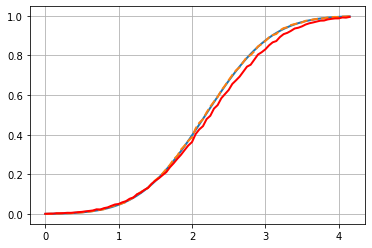

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import root

from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.gradient_descent import SGD
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.initializers import initializers_v1

from keras.models import model_from_json

from google.colab import drive
drive.mount('/content/drive')

def P_F(q_0):                       
  return 1 - norm.cdf(q_0)             #вычисление вероятности ложной  тревоги

def P_D(q_0, q):

  return 1 - norm.cdf(q_0 - np.sqrt(2*q))       #вычисление вероятности правильного обнаружения

def fun(d_q):
  return P_F(d_q) - F


def find_q_0():
  return root(fun, np.array([0]), method = 'hybr')



def correlator(realization, signal_s, delta_t):
  return delta_t * realization.dot(signal_s)



def edu_vyborka_gen(num_s, num_n, sigma, t, signal_s):
  edu_s = []
  target_s = []
  edu_n = []
  target_n = []

  for i in range(num_s):

    #генерация реализаций с сигналом
    noise = sigma * np.random.randn(len(t))
    realization = signal_s + noise
    edu_s.append(realization)
    target_s.append(1)

  for i in range(num_n):
    #генерация реализаций без сигнала (только шум)
    noise = sigma * np.random.randn(len(t))
    realization = noise
    edu_n.append(realization)
    target_n.append(0)

  edu_s = np.asarray(edu_s)
  edu_n = np.asarray(edu_n)

  target_s = np.asarray(target_s)
  target_n = np.asarray(target_n)

  edu = np.concatenate((edu_s, edu_n), axis = 0)
  targets = np.concatenate((target_s, target_n), axis = 0)

  return edu, targets




def test_vyborka_gen(sigma, num_all, t, signal_s):
  test_s = []
  test_n = []


  for i in range(num_all):

    #генерация реализациий с сигналом

    noise = sigma * np.random.randn(len(t))
    realization = signal_s + noise
    test_s.append(realization)


    #генерация реализаций только с шумом, без сигнала

    noise = sigma * np.random.randn(len(t))
    realization = noise
    test_n.append(realization)


  test_s = np.asarray(test_s)
  test_n = np.asarray(test_n)

  return test_s, test_n


#load model

json_file = open('/content/drive/My Drive/Files_of_detecting/model_five.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/My Drive/Files_of_detecting/model_five.h5")
print("Loaded model from disk")


#параметры простого радиоимпульса, который нужно обнаружить


f_pch = 30*(10**3)
T = 1*(10**(-3))
phi_0 = 0

f_d = 1/T
T_d = 1/f_d

f_d_1 = 20*f_pch
T_d_1 = 1/f_d_1        #две частоты дискретизации, первая - после РЧБ, до обнаружителя

sigma_n = 1  #СКО АБГШ

#из СКО перейдем к спектральной плотности мощности АБГШ

N_0 = 2*sigma_n*sigma_n/f_d_1


#root_q = np.array([0, 0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7])  #variating SNR

root_q = np.arange(0, 4.2, 0.05)

optimal_P_D = []
corr_P_D = []
corr_P_F = []
neuro_P_D = []
neuro_P_F = []

for r_q in root_q:

  E = r_q*r_q*N_0

  A = np.sqrt(2*E/T)   #находим амплитуду сигнала


  num = np.fix(T/T_d_1)
  num = np.int(num)

  t = np.linspace(0, T, num)

  print('A =', A)

  signal = A*np.cos(2 * np.pi * f_pch * t + phi_0)     #модель сигнала



  #найдем количество выборок сигнала и шума

  F = 0.001       #требуемая вероятность ложной тревоги

  q_0 = find_q_0().x[0]    #важно перейти к соотношению априорных вероятностей

  z_0 = q_0*r_q*np.sqrt(2)


  h = np.exp(z_0 - r_q*r_q)

  print(h)

  edu_num = 90000 #варьируемый параметр - это количество реализациий, которые будцт переданы для обучения

  num_signal = int(edu_num/(1+h))      #количество реализаций с сигналом в обучающей выборке
  num_noise = edu_num - num_signal     #количество реализаций с шумом в обучабщей выборке

  test_num = 10000                     #количетсво реализаций в тестовой выборке

  #генерируем обучающую выборку


  #edu_data_no, targets = edu_vyborka_gen(num_signal, num_noise, sigma_n, t, signal)

  #targets = targets.reshape(len(targets), 1)
  #scaler = MinMaxScaler()

  #edu_data = scaler.fit_transform(edu_data_no)

  #генерируем тестовую выборку

  tests_signal, tests_noise = test_vyborka_gen(sigma_n, test_num, t, signal)

  P_D_theory = P_D(q_0, r_q*r_q)

  optimal_P_D.append(P_D_theory)


  y_pred_signals = model.predict(tests_signal)
  y_pred_noise = model.predict(tests_noise)



  P_D_est = 0
  P_F_est = 0

  P_D_est_nn = 0
  P_F_est_nn = 0 

  for i in range(len(tests_signal)):

    #сигнал есть в реализации, считаем оценку вероятности правильного обнаружения

    E = root_q[-2]*root_q[-2]*N_0

    A = np.sqrt(2*E/T)   #находим амплитуду сигнала


    num = np.fix(T/T_d_1)
    num = np.int(num)



    signal = A*np.cos(2 * np.pi * f_pch * t + phi_0)     #модель сигнала

    corr_res = (2/N_0)*correlator(tests_signal[i], signal, T_d_1)

    z_0 = q_0*root_q[-2]*np.sqrt(2)

    if corr_res >= z_0:
      P_D_est = P_D_est + 1
    #print(corr_res)

    #сигнала нет в реализации, считаем вероятность ложной тревоги

    corr_res_n = (2/N_0)*correlator(tests_noise[i], signal, T_d_1)

    if corr_res_n >= z_0:
      P_F_est = P_F_est + 1



    if y_pred_signals[i] >= 0.5:
      P_D_est_nn = P_D_est_nn + 1

    if y_pred_noise[i] >= 0.5:
      P_F_est_nn = P_F_est_nn + 1


  P_D_est = P_D_est/len(tests_signal)
  P_F_est = P_F_est/len(tests_noise)

  P_D_est_nn = P_D_est_nn/len(tests_signal)
  P_F_est_nn = P_F_est_nn/len(tests_noise)

  corr_P_D.append(P_D_est)
  corr_P_F.append(P_F_est)

  neuro_P_D.append(P_D_est_nn)
  neuro_P_F.append(P_F_est_nn)

  #сбор вероятностей

corr_P_D = np.asarray(corr_P_D)
optimal_P_D = np.asarray(optimal_P_D)
neuro_P_D = np.asarray(neuro_P_D)

plt.plot(root_q, optimal_P_D, linewidth = 2.0)
plt.plot(root_q, corr_P_D, linestyle = '--', linewidth = 2.0)
plt.plot(root_q, neuro_P_D, c = 'r', linewidth = 2.0)
#plt.plot(root_q, neuro_P_D, color = 'r')
plt.grid(True)
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0.0012 0.002  0.0021 0.0041 0.004  0.0048 0.0063 0.0061 0.008  0.0096
 0.0111 0.0139 0.0158 0.0182 0.024  0.0228 0.0298 0.0336 0.0414 0.0483
 0.0509 0.0593 0.0651 0.0772 0.0833 0.0998 0.1078 0.122  0.132  0.153
 0.1683 0.1809 0.1966 0.2115 0.2363 0.2562 0.2786 0.2989 0.3229 0.3461
 0.363  0.4035 0.4272 0.4434 0.4793 0.4958 0.5321 0.5497 0.5843 0.6054
 0.6258 0.6565 0.6745 0.6935 0.7186 0.7437 0.7533 0.7791 0.8048 0.8164
 0.8308 0.8509 0.8663 0.8729 0.8933 0.9078 0.9142 0.9243 0.9361 0.9401
 0.9469 0.9563 0.9625 0.9665 0.9712 0.9756 0.9763 0.9818 0.9847 0.987
 0.9872 0.9917 0.991  0.9946]
[7.000e-04 9.000e-04 1.500e-03 2.300e-03 3.100e-03 3.700e-03 3.800e-03
 4.200e-03 5.900e-03 7.000e-03 8.300e-03 1.060e-02 1.230e-02 1.500e-02
 2.080e-02 2.140e-02 2.420e-02 3.120e-02 3.880e-02 4.290e-02 4.680e-02
 5.460e-02 5.960e-02 7.300e-02 8.370e-02 9.820e-02 1.107e-01 1

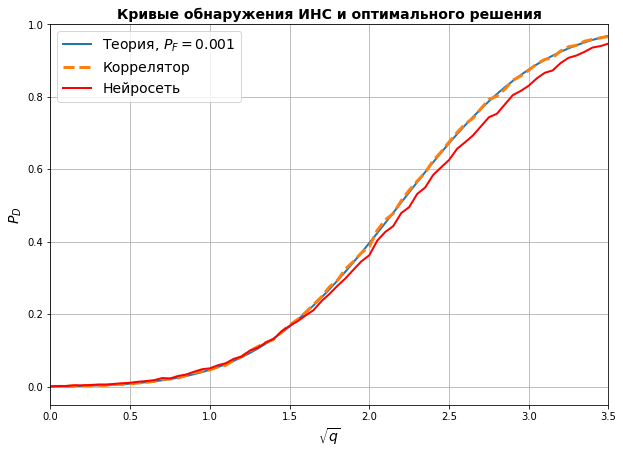

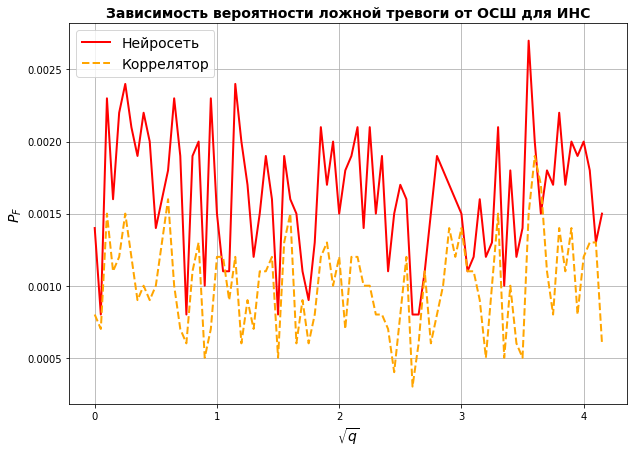

In [29]:
drive.mount('/content/drive')

plt.figure(figsize = (10, 7))
plt.title('Кривые обнаружения ИНС и оптимального решения', fontsize = 14, fontweight = 'bold')
plt.plot(root_q, optimal_P_D, linewidth = 2.0, label = 'Теория, $P_F = 0.001$')
plt.plot(root_q, corr_P_D, linestyle = '--', linewidth = 3.0, label = 'Коррелятор')
plt.plot(root_q, neuro_P_D, color = 'r', linewidth = 2.0, label = 'Нейросеть')
plt.xlabel('$\sqrt{q}$', fontsize = 14)
plt.axis([0, 3.5, -0.05, 1])
plt.ylabel('$P_D$', fontsize = 14)
plt.grid(True)
plt.legend(fontsize = 14)
#plt.show()

print(neuro_P_D)
print(corr_P_D)
print(optimal_P_D)

plt.savefig('/content/drive/My Drive/Files_of_detecting/Curves_det_five.png')


plt.figure(figsize = (10, 7))
plt.plot(root_q, neuro_P_F, color = 'r', linewidth = 2.0, label = 'Нейросеть')
plt.plot(root_q, corr_P_F, color = 'orange', linestyle = '--', linewidth = 2.0, label = 'Коррелятор')
plt.title('Зависимость вероятности ложной тревоги от ОСШ для ИНС', fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 14)
plt.xlabel('$\sqrt{q}$', fontsize = 14)
plt.ylabel('$P_F$', fontsize = 14)

plt.grid(True)

plt.savefig('/content/drive/My Drive/Files_of_detecting/Curve_P_F_five.png')

False


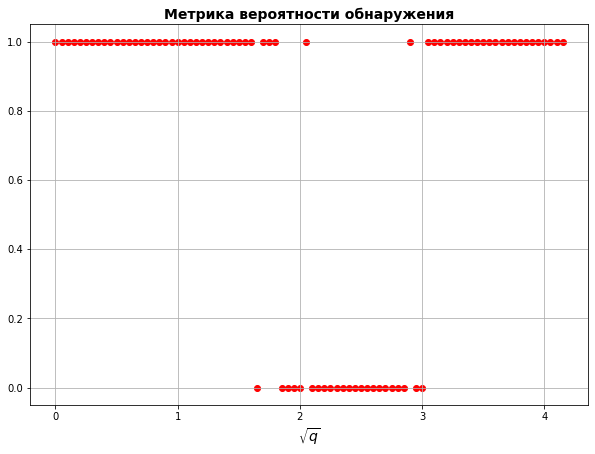

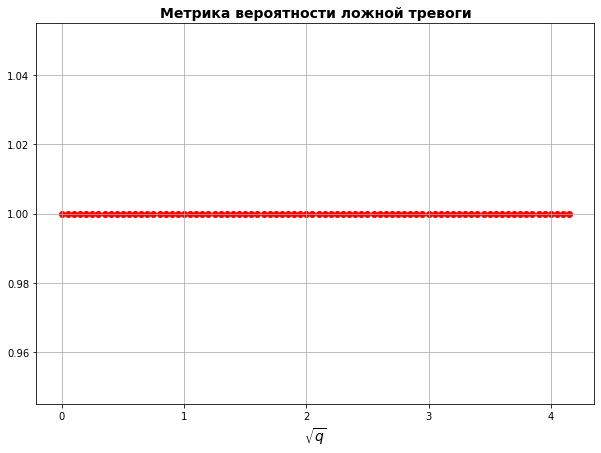

In [30]:
#проверка метрик

a = np.array([1, 2, 3, 4, 5])

aa = np.array([-1, 1, 3, -5, -11])

if all(a > aa):
  print(True)
else:
  print('False')

#if all(P_D_est_nn  >= P_D_theory):
  #print('True')

metric_us_d = []
metric_us_f = []
for p_d_nn, p_d_opt in zip(neuro_P_D, optimal_P_D):
  if p_d_nn >= 0.95*p_d_opt:
    metric_us_d.append(1)
  else:
    metric_us_d.append(0)

for p_f_nn in neuro_P_F:
  if p_f_nn <= 0.003:
    metric_us_f.append(1)
  else:
    metric_us_f.append(0)

metric_us_d = np.asarray(metric_us_d)
metric_us_f = np.asarray(metric_us_f)

plt.figure(figsize = (10, 7))
plt.scatter(root_q, metric_us_d, color = 'r', linewidth = 1.0)
#plt.plot(root_q, corr_P_F, color = 'orange', linestyle = '--', linewidth = 2.0, label = 'Коррелятор')
plt.title('Метрика вероятности обнаружения', fontsize = 14, fontweight = 'bold')
#plt.legend(fontsize = 14)
plt.xlabel('$\sqrt{q}$', fontsize = 14)
#plt.ylabel('$P_F$', fontsize = 14)
plt.grid(True)

plt.savefig('/content/drive/My Drive/Files_of_detecting/Curves_metric_pd_five.png')

plt.figure(figsize = (10, 7))
plt.scatter(root_q, metric_us_f, color = 'r', linewidth = 1.0)
#plt.plot(root_q, corr_P_F, color = 'orange', linestyle = '--', linewidth = 2.0, label = 'Коррелятор')
plt.title('Метрика вероятности ложной тревоги', fontsize = 14, fontweight = 'bold')
#plt.legend(fontsize = 14)
plt.xlabel('$\sqrt{q}$', fontsize = 14)
#plt.ylabel('$P_F$', fontsize = 14)
plt.grid(True)

plt.savefig('/content/drive/My Drive/Files_of_detecting/Curves_metric_pf_five.png')
